In [1]:
import numpy as np
import tensorflow as tf

In [2]:
data_dir = '../'

with np.load(data_dir+'\\T0l.npz') as eletr_score:
    for item in eletr_score.files:
        T0l = eletr_score[item]
with np.load(data_dir+'\\T1l.npz') as data_xS:
    for item in data_xS.files:
        T1l = data_xS[item]
with np.load(data_dir+'\\T2l.npz') as data_xS:
    for item in data_xS.files:
        T2l = data_xS[item]

print('Dataset .npz encontrado!')

Dataset .npz encontrado!


In [3]:
tam_data = 721

x1 = [T1l[:,i:i+tam_data] for i in range(0,len(T1l[0]),tam_data) if i+tam_data < len(T1l[0])]
x2 = [T2l[:,i:i+tam_data] for i in range(0,len(T2l[0]),tam_data) if i+tam_data < len(T2l[0])]
x1 = np.array(x1); x2 = np.array(x2)
print(x1.shape, x2.shape)

(326, 16, 721) (321, 16, 721)


In [4]:
x = np.concatenate((x1,x2),axis=0)
y = [0 for i in x1] + [1 for i in x2]
y = np.array(y)

print(f'{len(x1)} + {len(x2)} = {len(x1)+len(x2)}')
print(f'Tamanho de x: {x.shape}')

326 + 321 = 647
Tamanho de x: (647, 16, 721)


In [5]:
from sklearn.utils import shuffle
x, y = shuffle(x,y,random_state=0)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

In [ ]:
import keras
from keras_tuner import HyperModel
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [8]:
model = Sequential()

model.add(Conv1D(filters=20, kernel_size=(3,), activation='relu'))
model.add(Conv1D(filters=20, kernel_size=(6,), activation='relu'))
model.add(MaxPooling1D(pool_size=(2,)))
model.add(Flatten())
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy')

hist = model.fit(x_train,y_train, epochs=1,validation_data=(x_test,y_test))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6937 - val_loss: 0.6931


In [9]:
model(x_test)

<tf.Tensor: shape=(65, 1), dtype=float32, numpy=
array([[0.49689823],
       [0.49689138],
       [0.49690154],
       [0.49690235],
       [0.496899  ],
       [0.4968977 ],
       [0.49690396],
       [0.496897  ],
       [0.4969016 ],
       [0.49690646],
       [0.496899  ],
       [0.49689496],
       [0.4969042 ],
       [0.49690658],
       [0.496903  ],
       [0.4969101 ],
       [0.4968989 ],
       [0.49688935],
       [0.4968953 ],
       [0.49690098],
       [0.49690515],
       [0.49689344],
       [0.49690372],
       [0.49690074],
       [0.4969051 ],
       [0.49690303],
       [0.4969066 ],
       [0.49689364],
       [0.49690178],
       [0.4969022 ],
       [0.49690413],
       [0.49690443],
       [0.4968972 ],
       [0.49689722],
       [0.49689317],
       [0.49690348],
       [0.49690217],
       [0.4969012 ],
       [0.49689883],
       [0.49690306],
       [0.49690142],
       [0.49690562],
       [0.49689412],
       [0.4969039 ],
       [0.4968993 ],
      

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


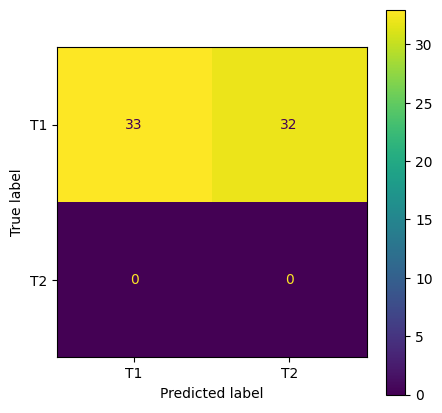

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

#Make predictions
y_probs = model.predict(x_test)
#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)
#Confusion matrix
cm=confusion_matrix(y_preds,y_test)
#
label_names = ["T1","T2"]
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)

In [11]:
model = Sequential([
    Conv1D(20, kernel_size=6, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Conv1D(20, kernel_size=6, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(60, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinamento por 35 épocas
history = model.fit(
    x_train, y_train,
    epochs=35,
    validation_data=(X_test, y_test),
    verbose=1
)


c:\Users\LaBios - BCI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'Adam' is not defined

Nota: não faz sentido usar SVM para arrays muito grandes, como os dados brutos.

## Testando SVM simples

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.sparse.linalg

svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(x_train.reshape(x_train.shape[0],-1), y_train)

ValueError: Found array with dim 3. SVC expected <= 2.

In [98]:
x_train.reshape(x_train.shape[0],-1).shape

(688, 11536)

In [99]:
y_train.shape

(688,)

In [94]:
# fazer previsões no conjunto de teste
y_pred = svm_model.predict(x_test)

# avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
accuracy

ValueError: Found array with dim 3. SVC expected <= 2.